# Experiments wi SA-PINN masks

Эта часть будет относена к приложению как эксперименты над выбором маски весов лосса. В оригинальной [статье]() на выбор представляется два вида маски: полиноминальная и сигмоидная. Для выбора вида маски здесь будут проведены эксперименты с использованием двух моделей: с использованием полиноминальной маски и с использованием сигмоидной маски, а также с частным видом полиноминальной маски - линейной. Все эксперименты будут проводиться с использование FFR, так как она на момент экспериментов показала себя более эффективной, чем базовая PINN.

In [ ]:
import sys
import os
import json
sys.path.append("..")

import torch
import torch.autograd as autograd
from torch.optim.lr_scheduler import LambdaLR, StepLR
import torch.optim as optim
import random 
import numpy as np
from scipy.stats import qmc

from tasks.burgers_1d import Burgers1D
from models.pinns import SA_PINN, PINN 
from models.utils import LambdaScheduler, PolynomialMask, SigmoidMask, LinearMask
from common.train_functions import *
from common.plotting import *
from common.saving_results import *

In [2]:
print("CUDA Version:", torch.version.cuda)
print(torch.backends.cudnn.enabled)  # Should be True
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))

CUDA Version: 12.8
True
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
# Fix random number generators
seed = 42
torch.manual_seed(seed)  # For PyTorch
random.seed(seed)        # For random
np.random.seed(seed)     # For NumPy

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
viscosity = 0.01 / np.pi  # Viscosity
burgers_1d = Burgers1D(nu=viscosity)

In [6]:
# Set number of data points
N_0 = 50
N_b = 50
N_d = 0
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

In [7]:
# Set boundaries
lb = torch.tensor([tmin, xmin], dtype=torch.float32, requires_grad=False)  # Lower bounds
ub = torch.tensor([tmax, xmax], dtype=torch.float32, requires_grad=False)  # Upper bounds

# Generate points for initial conditions
t_0 = torch.ones((N_0, 1), dtype=torch.float32, requires_grad=True) * lb[0]
x_0 = torch.rand((N_0, 1), dtype=torch.float32, requires_grad=True) * (ub[1] - lb[1]) + lb[1]
X_0 = torch.cat([t_0, x_0], dim=1)

# Compute initial condition at points x_0
u_0 = burgers_1d.initial_conditions(x_0)

# Generate points for boundary conditions
t_b = torch.rand((N_b, 1), dtype=torch.float32, requires_grad=True) * (ub[0] - lb[0]) + lb[0]
x_b = lb[1] + (ub[1] - lb[1]) * torch.bernoulli(torch.full((N_b, 1), 0.5, dtype=torch.float32))
x_b.requires_grad_(True)  # Set requires_grad=True for x_b
X_b = torch.cat([t_b, x_b], dim=1)

# Compute boundary condition at points (t_b, x_b)
u_b = burgers_1d.boundary_conditions(t_b)

# Generate points for collocation
sobol_sampler = qmc.Sobol(d=2, scramble=True)
X_r = sobol_sampler.random(n=N_r)
X_r = torch.tensor(qmc.scale(X_r, lb, ub), dtype=torch.float32, requires_grad=True)
t_r = X_r[:, 0:1]
x_r = X_r[:, 1:]

C:\Users\ritka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


## Plot generated points

Text(0.5, 1.0, 'Positions of collocation points and boundary data')

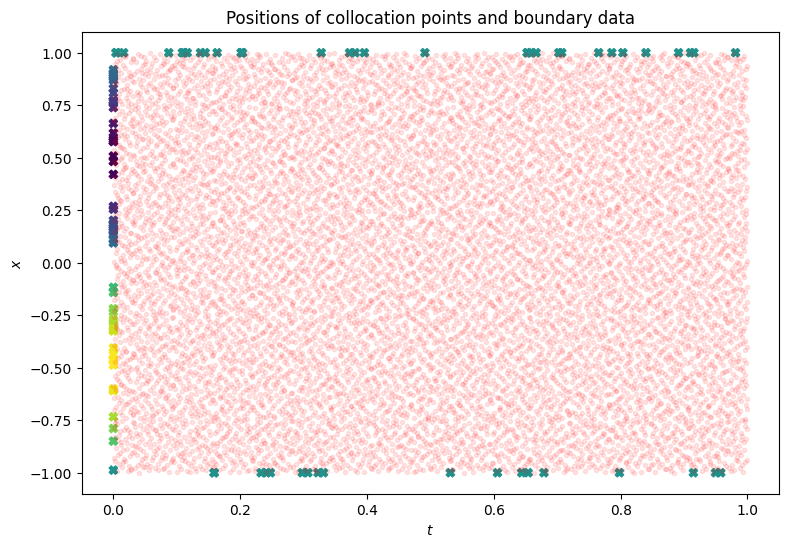

In [8]:
fig = plt.figure(figsize=(9, 6))
plt.scatter(t_0.detach().numpy(), x_0.detach().numpy(), c=u_0.detach().numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_b.detach().numpy(), x_b.detach().numpy(), c=u_b.detach().numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_r.detach().numpy(), x_r.detach().numpy(), c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data')
# plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

# Common hyperparameters for all models

In [9]:
N = 500
rff_features = 20
rff_layers = 9
lambda_step_size = 100
lambda_lr = 1e-4
weight_gamma = 0.85
max_epoch = 10000

# RFF-PINN without SA

In [10]:
# Set training parameters
rff_pinn = PINN(
    input_dim=2,
    rff_features=rff_features,
    output_dim=1,
    hidden_layers= 9 * [2 * rff_features + 2],
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(rff_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=weight_gamma)
}

In [11]:
rff_pinn.to(device)
train_loss, eval_losses = train_pinn(
    max_epoch, 
    rff_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device
)

C:\Users\ritka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 50/10000, PINN Loss: 0.25342, True Loss: 0.24491
Epoch: 100/10000, PINN Loss: 0.15792, True Loss: 0.15780
Epoch: 150/10000, PINN Loss: 0.15540, True Loss: 0.15534
Epoch: 200/10000, PINN Loss: 0.14822, True Loss: 0.14790
Epoch: 250/10000, PINN Loss: 0.12282, True Loss: 0.12214
Epoch: 300/10000, PINN Loss: 0.10369, True Loss: 0.10299
Epoch: 350/10000, PINN Loss: 0.09149, True Loss: 0.08709
Epoch: 400/10000, PINN Loss: 0.05931, True Loss: 0.05828
Epoch: 450/10000, PINN Loss: 0.04593, True Loss: 0.04379
Epoch: 500/10000, PINN Loss: 0.03932, True Loss: 0.03895
Epoch: 550/10000, PINN Loss: 0.03618, True Loss: 0.03732
Epoch: 600/10000, PINN Loss: 0.03690, True Loss: 0.03591
Epoch: 650/10000, PINN Loss: 0.03243, True Loss: 0.03268
Epoch: 700/10000, PINN Loss: 0.03367, True Loss: 0.03289
Epoch: 750/10000, PINN Loss: 0.03537, True Loss: 0.03313
Epoch: 800/10000, PINN Loss: 0.02519, True Loss: 0.02522
Epoch: 850/10000, PINN Loss: 0.02499, True Loss: 0.02788
Epoch: 900/10000, PINN Loss: 0.0

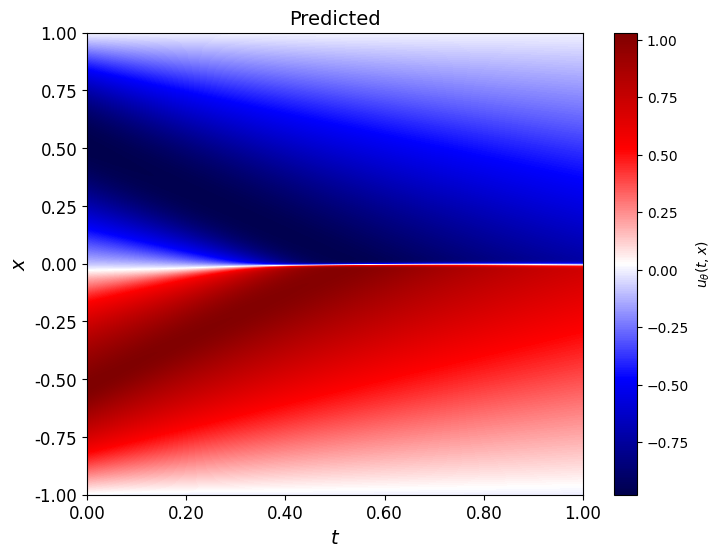

In [12]:
rff_pinn.to("cpu")
T, X, U = compute_approximation_2d(rff_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

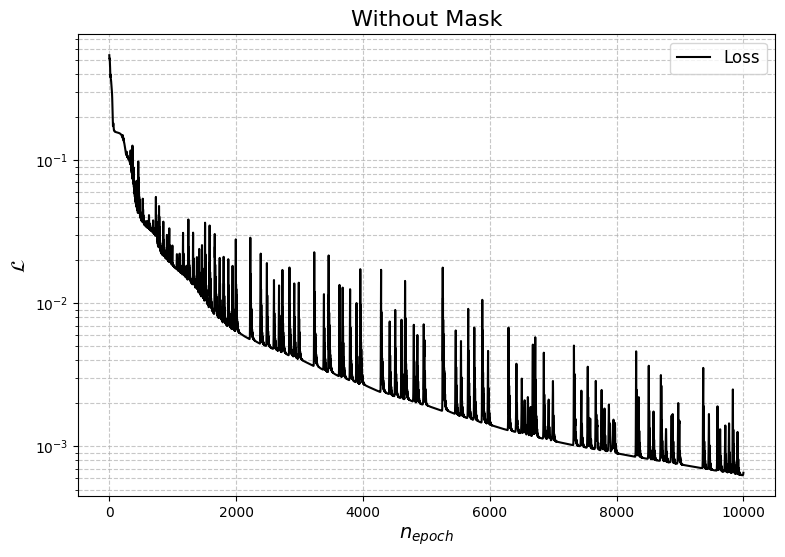

In [13]:
plot_loss(eval_losses, title="Without Mask")

In [14]:
save_u_results(T, X, U, os.path.join("..", "data", "sapinn_mask", "results", "without.json"))
save_eval_losses(eval_losses, os.path.join("..", "data", "sapinn_mask", "loss", "without.json"))
save_model(rff_pinn, os.path.join("..", "saved_models", "sapinn_mask", "without.pt"))

# SA-PINN with polynomial mask function

In [17]:
# Set training parameters
poly_name = "Polynomial Mask"
poly_sapinn = SA_PINN(
    input_dim=2,
    output_dim=1,
    rff_features=rff_features,
    activation=torch.nn.Tanh(),
    mask_class=PolynomialMask,
    hidden_layers= 9 * [rff_features * 2 + 2],
    equation=burgers_1d,
    points_pde=X_r,
    points_ics=X_0,
    points_bcs=X_b
).to(device)
optimizers = {
    "model": optim.Adam(poly_sapinn.u_model.parameters(), lr=1e-3),
    "lambdas_pde": optim.Adam([poly_sapinn.lambdas_pde], lr=lambda_lr),
    "lambdas_ics": optim.Adam([poly_sapinn.lambdas_ics], lr=lambda_lr),
    "lambdas_bcs": optim.Adam([poly_sapinn.lambdas_bcs], lr=lambda_lr)
}
schedulers = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=weight_gamma),
    "lambdas_pde": LambdaScheduler(optimizers["lambdas_pde"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9),
    "lambdas_ics": LambdaScheduler(optimizers["lambdas_ics"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9),
    "lambdas_bcs": LambdaScheduler(optimizers["lambdas_bcs"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9)
}

C:\Users\ritka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [18]:
poly_sapinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    poly_sapinn, optimizers, schedulers,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device
)

Epoch: 50/10000, PINN Loss: 0.20331, True Loss: 0.18962
Epoch: 100/10000, PINN Loss: 0.15897, True Loss: 0.15898
Epoch: 150/10000, PINN Loss: 0.15778, True Loss: 0.15776
Epoch: 200/10000, PINN Loss: 0.15660, True Loss: 0.15657
Epoch: 250/10000, PINN Loss: 0.15492, True Loss: 0.15488
Epoch: 300/10000, PINN Loss: 0.14938, True Loss: 0.14894
Epoch: 350/10000, PINN Loss: 0.11696, True Loss: 0.11645
Epoch: 400/10000, PINN Loss: 0.09103, True Loss: 0.09103
Epoch: 450/10000, PINN Loss: 0.06505, True Loss: 0.06658
Epoch: 500/10000, PINN Loss: 0.03296, True Loss: 0.03211
Epoch: 550/10000, PINN Loss: 0.01885, True Loss: 0.01815
Epoch: 600/10000, PINN Loss: 0.01491, True Loss: 0.01503
Epoch: 650/10000, PINN Loss: 0.01408, True Loss: 0.01374
Epoch: 700/10000, PINN Loss: 0.01476, True Loss: 0.01361
Epoch: 750/10000, PINN Loss: 0.00866, True Loss: 0.00869
Epoch: 800/10000, PINN Loss: 0.00789, True Loss: 0.00777
Epoch: 850/10000, PINN Loss: 0.01006, True Loss: 0.01149
Epoch: 900/10000, PINN Loss: 0.0

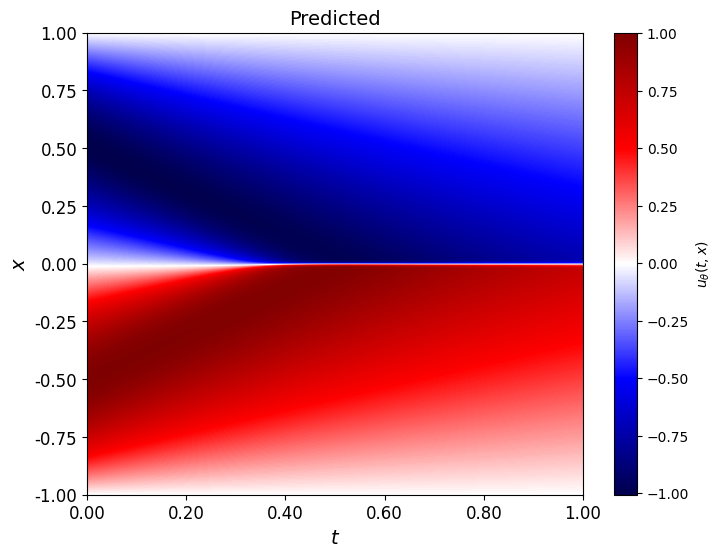

In [19]:
N = 500
poly_sapinn.to("cpu")
T, X, U = compute_approximation_2d(poly_sapinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

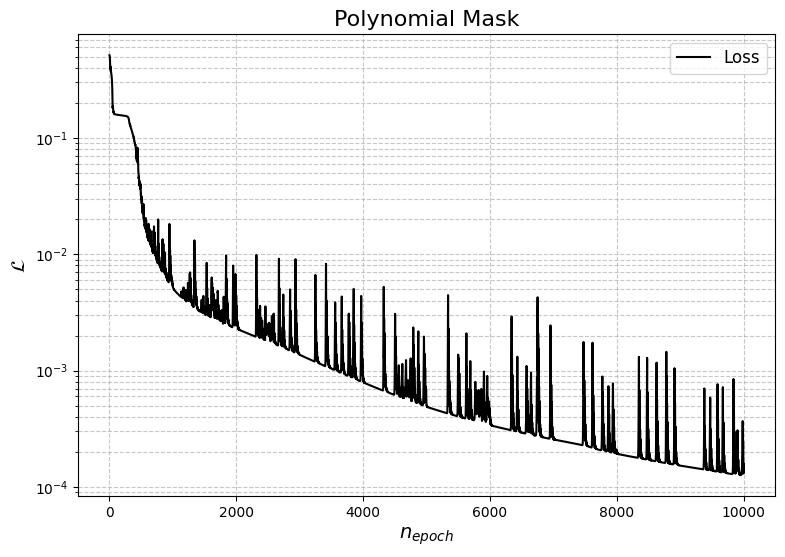

In [20]:
plot_loss(eval_loss, title=poly_name)

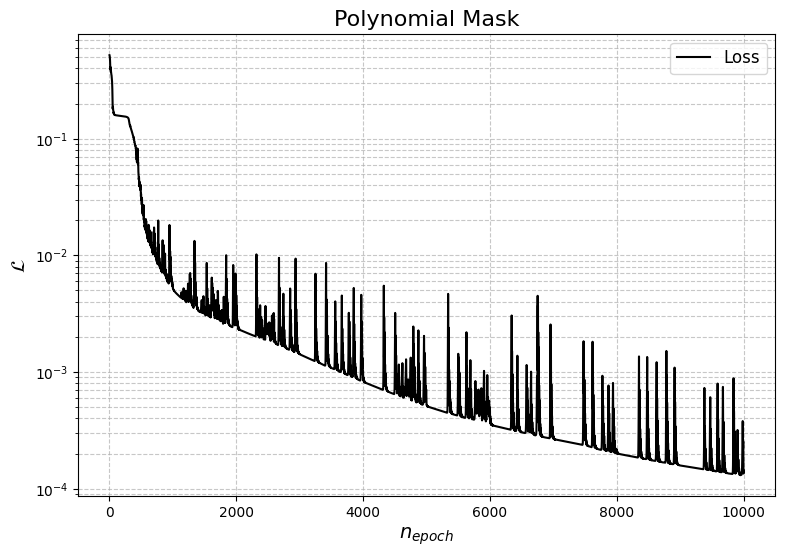

In [21]:
plot_loss(train_loss, title=poly_name)

In [22]:
save_u_results(T, X, U, os.path.join("..", "data", "sapinn_mask", "results", "poly.json"))
save_eval_losses(eval_loss, os.path.join("..", "data", "sapinn_mask", "loss", "poly.json"))
save_model(poly_sapinn, os.path.join("..", "saved_models", "sapinn_mask", "poly.pt"))

# SAPINN with sigmoid mask function

In [23]:
# Set training parameters
sigm_name = "Sigmoid Mask"
sigm_sapinn = SA_PINN(
    input_dim=2,
    output_dim=1,
    rff_features=rff_features,
    activation=torch.nn.Tanh(),
    mask_class=SigmoidMask,
    hidden_layers= 9 * [2 * rff_features + 2],
    equation=burgers_1d,
    points_pde=X_r,
    points_ics=X_0,
    points_bcs=X_b
).to(device)
optimizers = {
    "model": optim.Adam(sigm_sapinn.u_model.parameters(), lr=1e-3),
    "lambdas_pde": optim.Adam([sigm_sapinn.lambdas_pde], lr=lambda_lr),
    "lambdas_ics": optim.Adam([sigm_sapinn.lambdas_ics], lr=lambda_lr),
    "lambdas_bcs": optim.Adam([sigm_sapinn.lambdas_bcs], lr=lambda_lr)
}
schedulers = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=weight_gamma),
    "lambdas_pde": LambdaScheduler(optimizers["lambdas_pde"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9),
    "lambdas_ics": LambdaScheduler(optimizers["lambdas_ics"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9),
    "lambdas_bcs": LambdaScheduler(optimizers["lambdas_bcs"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9)
}

In [24]:
sigm_sapinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    sigm_sapinn, optimizers, schedulers,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device
)

Epoch: 50/10000, PINN Loss: 0.28158, True Loss: 0.28008
Epoch: 100/10000, PINN Loss: 0.16235, True Loss: 0.16404
Epoch: 150/10000, PINN Loss: 0.15316, True Loss: 0.15588
Epoch: 200/10000, PINN Loss: 0.14804, True Loss: 0.15055
Epoch: 250/10000, PINN Loss: 0.12192, True Loss: 0.12378
Epoch: 300/10000, PINN Loss: 0.09212, True Loss: 0.09469
Epoch: 350/10000, PINN Loss: 0.06639, True Loss: 0.06756
Epoch: 400/10000, PINN Loss: 0.05370, True Loss: 0.05666
Epoch: 450/10000, PINN Loss: 0.01995, True Loss: 0.02180
Epoch: 500/10000, PINN Loss: 0.01529, True Loss: 0.01509
Epoch: 550/10000, PINN Loss: 0.01429, True Loss: 0.01802
Epoch: 600/10000, PINN Loss: 0.00941, True Loss: 0.00958
Epoch: 650/10000, PINN Loss: 0.00777, True Loss: 0.00910
Epoch: 700/10000, PINN Loss: 0.00702, True Loss: 0.00806
Epoch: 750/10000, PINN Loss: 0.00581, True Loss: 0.00613
Epoch: 800/10000, PINN Loss: 0.00771, True Loss: 0.00901
Epoch: 850/10000, PINN Loss: 0.00418, True Loss: 0.00424
Epoch: 900/10000, PINN Loss: 0.0

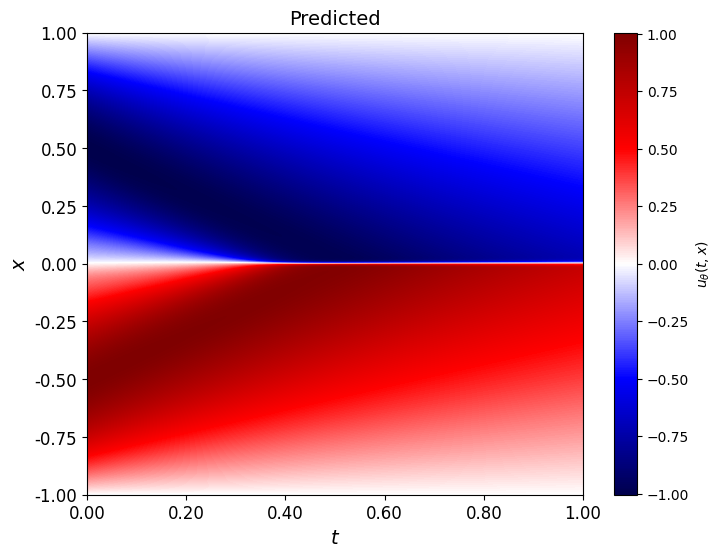

In [25]:
N = 500
sigm_sapinn.to("cpu")
T, X, U = compute_approximation_2d(sigm_sapinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

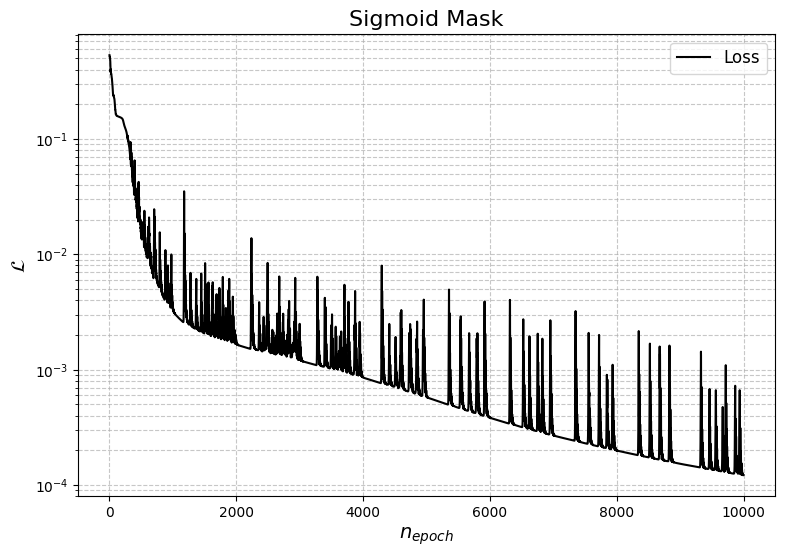

In [26]:
plot_loss(eval_loss, title=sigm_name)

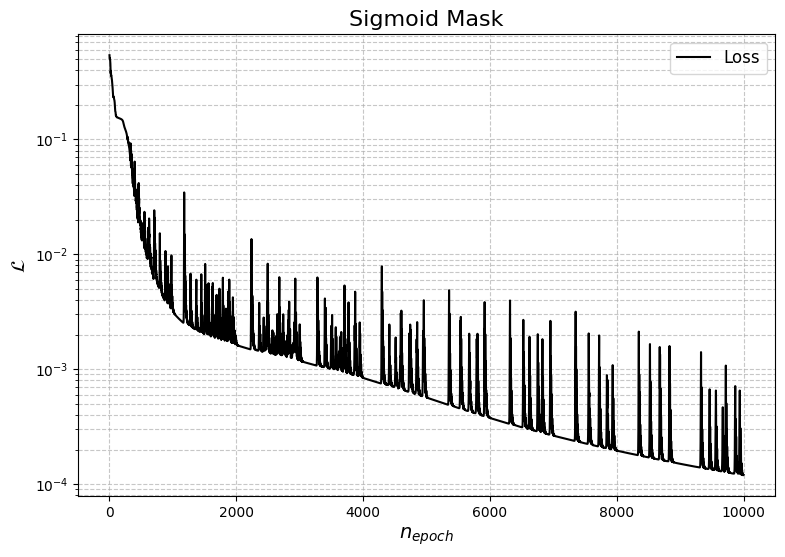

In [27]:
plot_loss(train_loss, title=sigm_name)

In [28]:
save_u_results(T, X, U, os.path.join("..", "data", "sapinn_mask", "results", "sigm.json"))
save_eval_losses(eval_loss, os.path.join("..", "data", "sapinn_mask", "loss", "sigm.json"))
save_model(poly_sapinn, os.path.join("..", "saved_models", "sapinn_mask", "sigm.pt"))

# SAPINN with linear mask function

In [29]:
# Set training parameters
lin_name = "Linear Mask"
lin_sapinn = SA_PINN(
    input_dim=2,
    output_dim=1,
    rff_features=rff_features,
    activation=torch.nn.Tanh(),
    mask_class=LinearMask,
    hidden_layers= 9 * [2 * rff_features + 2],
    equation=burgers_1d,
    points_pde=X_r,
    points_ics=X_0,
    points_bcs=X_b
).to(device)
optimizers = {
    "model": optim.Adam(lin_sapinn.u_model.parameters(), lr=1e-3),
    "lambdas_pde": optim.Adam([lin_sapinn.lambdas_pde], lr=lambda_lr),
    "lambdas_ics": optim.Adam([lin_sapinn.lambdas_ics], lr=lambda_lr),
    "lambdas_bcs": optim.Adam([lin_sapinn.lambdas_bcs], lr=lambda_lr)
}
schedulers = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=weight_gamma),
    "lambdas_pde": LambdaScheduler(optimizers["lambdas_pde"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9),
    "lambdas_ics": LambdaScheduler(optimizers["lambdas_ics"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9),
    "lambdas_bcs": LambdaScheduler(optimizers["lambdas_bcs"], N_warmup=1000, base_scheduler=optim.lr_scheduler.StepLR, step_size=lambda_step_size,gamma=0.9)
}

In [30]:
lin_sapinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    lin_sapinn, optimizers, schedulers,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device
)

Epoch: 50/10000, PINN Loss: 0.26177, True Loss: 0.25101
Epoch: 100/10000, PINN Loss: 0.21622, True Loss: 0.21615
Epoch: 150/10000, PINN Loss: 0.21132, True Loss: 0.21115
Epoch: 200/10000, PINN Loss: 0.13751, True Loss: 0.14004
Epoch: 250/10000, PINN Loss: 0.10900, True Loss: 0.10862
Epoch: 300/10000, PINN Loss: 0.09247, True Loss: 0.09397
Epoch: 350/10000, PINN Loss: 0.06436, True Loss: 0.05986
Epoch: 400/10000, PINN Loss: 0.05580, True Loss: 0.05216
Epoch: 450/10000, PINN Loss: 0.04103, True Loss: 0.04066
Epoch: 500/10000, PINN Loss: 0.04241, True Loss: 0.03626
Epoch: 550/10000, PINN Loss: 0.03359, True Loss: 0.03363
Epoch: 600/10000, PINN Loss: 0.03376, True Loss: 0.03712
Epoch: 650/10000, PINN Loss: 0.03157, True Loss: 0.03150
Epoch: 700/10000, PINN Loss: 0.03201, True Loss: 0.03176
Epoch: 750/10000, PINN Loss: 0.02949, True Loss: 0.02983
Epoch: 800/10000, PINN Loss: 0.03677, True Loss: 0.04660
Epoch: 850/10000, PINN Loss: 0.02242, True Loss: 0.02661
Epoch: 900/10000, PINN Loss: 0.0

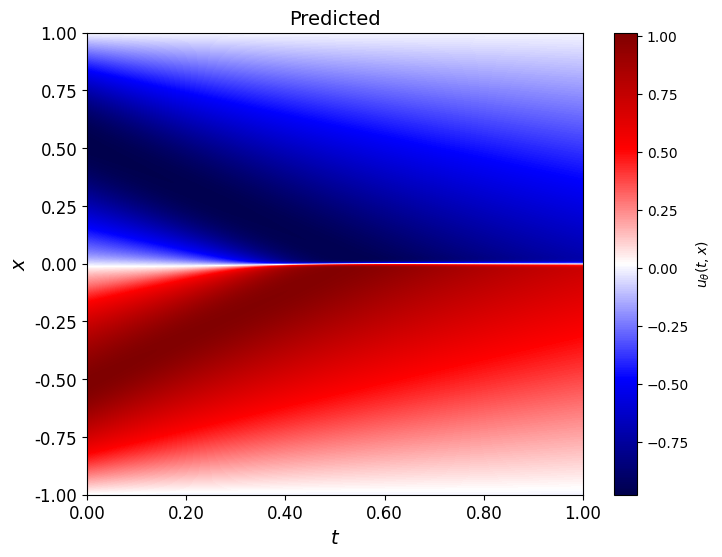

In [31]:
N = 500
lin_sapinn.to("cpu")
T, X, U = compute_approximation_2d(lin_sapinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

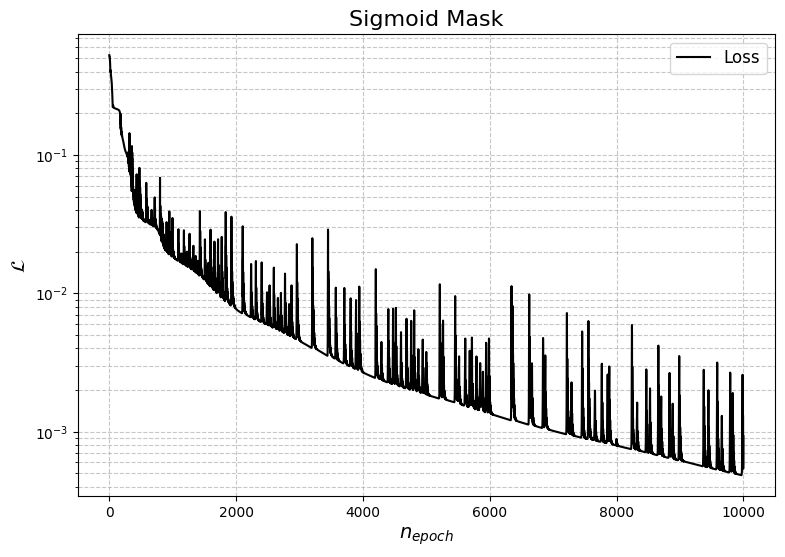

In [32]:
plot_loss(eval_loss, title=sigm_name)

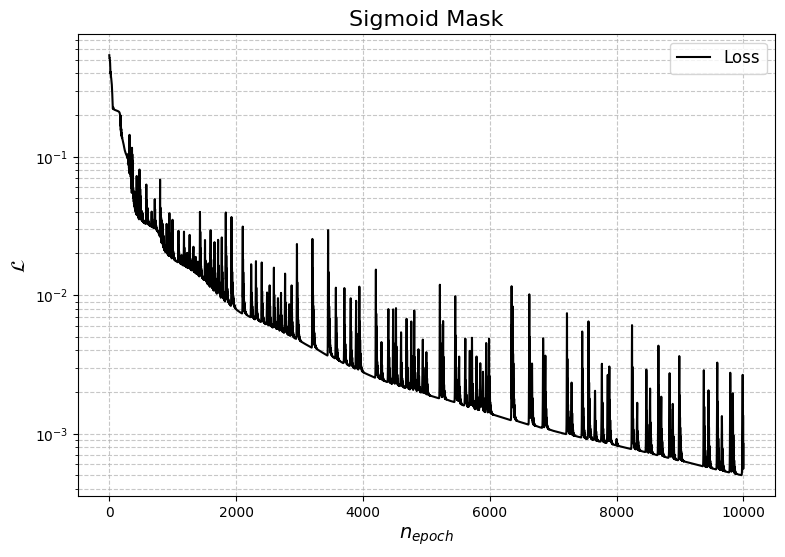

In [33]:
plot_loss(train_loss, title=sigm_name)

In [34]:
save_u_results(T, X, U, os.path.join("..", "data", "sapinn_mask", "results", "lin.json"))
save_eval_losses(eval_loss, os.path.join("..", "data", "sapinn_mask", "loss", "lin.json"))
save_model(poly_sapinn, os.path.join("..", "saved_models", "sapinn_mask", "lin.pt"))

# Comparasion

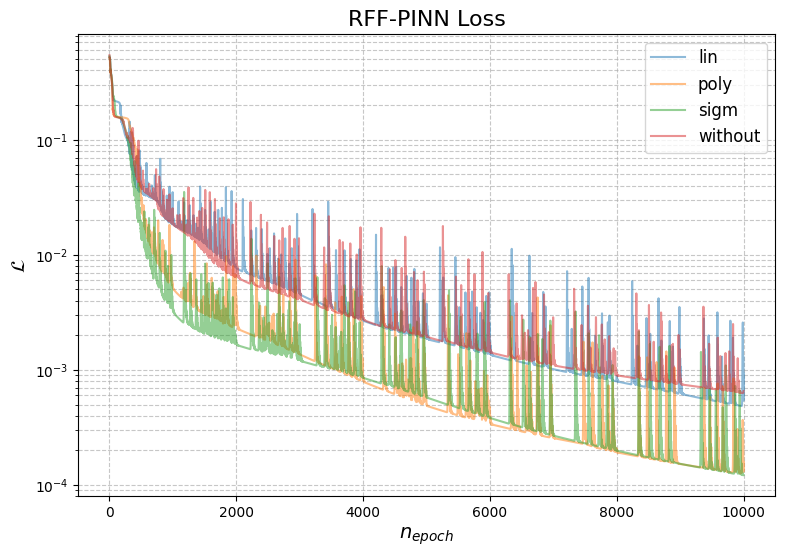

In [4]:
# отрисовка сохраненных графиков
mask_path = ["lin", "poly", "sigm", "without"]
losses = dict(zip(mask_path, [None] * len(mask_path)))
for mask in mask_path:
    with open(os.path.join("..", "data", "sapinn_mask", "loss",  f"{mask}.json")) as f:
        data = json.load(f)
    losses[mask] = data
plot_loss(
    losses, title="RFF-PINN Loss", alpha=0.5,
    # save_path=os.path.join("..", "pics", "1d_burgers", "loss", "rff_pinn_v001divpi.png")
)

## RFF-PINN then finetuning

In [42]:
finetune_optimizer = {
    "model": optim.Adam(rff_pinn.parameters(), lr=1e-4)
}
eval_losses = rad_finetune_pinn(10000, rff_pinn, finetune_optimizer, {}, X_r, X_0, X_b, resample_every_N=1000, resample_percent=0.3, k=4)

Finetuning model on resampled data...
Epoch: 50/1000, PINN Loss: 0.00066, True Loss: 0.00075
Epoch: 100/1000, PINN Loss: 0.00055, True Loss: 0.00055
Epoch: 150/1000, PINN Loss: 0.00054, True Loss: 0.00054
Epoch: 200/1000, PINN Loss: 0.00054, True Loss: 0.00054
Epoch: 250/1000, PINN Loss: 0.00054, True Loss: 0.00054
Epoch: 300/1000, PINN Loss: 0.00054, True Loss: 0.00054
Epoch: 350/1000, PINN Loss: 0.00053, True Loss: 0.00053
Epoch: 400/1000, PINN Loss: 0.00053, True Loss: 0.00053
Epoch: 450/1000, PINN Loss: 0.00053, True Loss: 0.00053
Epoch: 500/1000, PINN Loss: 0.00053, True Loss: 0.00053
Epoch: 550/1000, PINN Loss: 0.00053, True Loss: 0.00053
Epoch: 600/1000, PINN Loss: 0.00053, True Loss: 0.00053
Epoch: 650/1000, PINN Loss: 0.00052, True Loss: 0.00052
Epoch: 700/1000, PINN Loss: 0.00052, True Loss: 0.00052
Epoch: 750/1000, PINN Loss: 0.00052, True Loss: 0.00055
Epoch: 800/1000, PINN Loss: 0.00052, True Loss: 0.00052
Epoch: 850/1000, PINN Loss: 0.00052, True Loss: 0.00052
Epoch: 900/

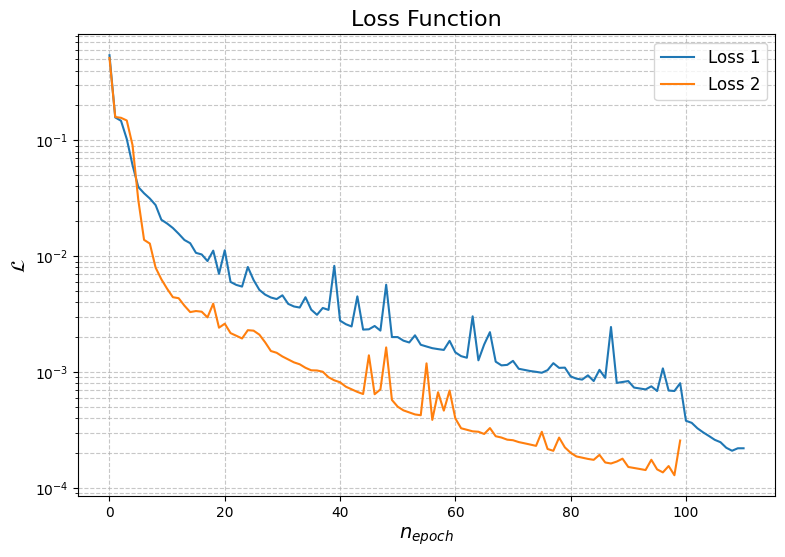

In [47]:
plot_loss([losses["without"] + eval_losses, losses["poly"]])